In [ ]:
GCS_PATH = {'stanford-rna':"gs://kds-f9fd75432c5da464280ddfb8ad919af48b3a554336793bd9c9703f85",
'tfrec':"gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688"}
print(GCS_PATH)

{'stanford-rna': 'gs://kds-f9fd75432c5da464280ddfb8ad919af48b3a554336793bd9c9703f85', 'tfrec': 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688'}


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shutil
import math
import pandas as pd
import gc
import os

In [ ]:
TRAIN_FILENAMES = tf.io.gfile.glob(GCS_PATH['tfrec']+'/tfds/*')
print(TRAIN_FILENAMES)

['gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/0.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/1.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/10.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/100.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/101.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/102.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/103.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/104.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/105.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/106.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/107.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d

In [ ]:
# Configure Strategy. Assume TPU...if not set default for GPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
    print("REPLICAS: ", strategy.num_replicas_in_sync)
except:
    strategy = tf.distribute.get_strategy()
    print('on CPU')

on TPU
REPLICAS:  8


In [ ]:
DEBUG = False

PAD_x = 0.0
PAD_y = np.nan
X_max_len = 304 #206
batch_size = 128
val_batch_size = 5512


if DEBUG:
    batch_size = 8
    val_batch_size = 8

num_vocab = 5
hidden_dim = 192

In [ ]:
# tffiles_path = '/kaggle/input/srrf-tfrecords-ds/tfds'
# tffiles = [f'{tffiles_path}/{x}.tfrecord' for x in range(164)]
tffiles = [GCS_PATH['tfrec']+f'/tfds/{x}.tfrecord' for x in range(164)]
print(tffiles)

['gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/0.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/1.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/2.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/3.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/4.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/5.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/6.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/7.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/8.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/9.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d688/tfds/10.tfrecord', 'gs://kds-31b5017f72ffef4d37161c76ed1656aabcd7d43445a3ee175dd7d

In [ ]:
def decode_tfrec(record_bytes):
    schema = {}
    schema["id"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["seq"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["dataset_name_2A3"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["dataset_name_DMS"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["reads_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reads_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["signal_to_noise_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["signal_to_noise_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["SN_filter_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["SN_filter_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_error_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_error_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    features = tf.io.parse_single_example(record_bytes, schema)

    sample_id = tf.sparse.to_dense(features["id"])
    seq = tf.sparse.to_dense(features["seq"])
    dataset_name_2A3 = tf.sparse.to_dense(features["dataset_name_2A3"])
    dataset_name_DMS = tf.sparse.to_dense(features["dataset_name_DMS"])
    reads_2A3 = tf.sparse.to_dense(features["reads_2A3"])
    reads_DMS = tf.sparse.to_dense(features["reads_DMS"])
    signal_to_noise_2A3 = tf.sparse.to_dense(features["signal_to_noise_2A3"])
    signal_to_noise_DMS = tf.sparse.to_dense(features["signal_to_noise_DMS"])
    SN_filter_2A3 = tf.sparse.to_dense(features["SN_filter_2A3"])
    SN_filter_DMS = tf.sparse.to_dense(features["SN_filter_DMS"])
    reactivity_2A3 = tf.sparse.to_dense(features["reactivity_2A3"])
    reactivity_DMS = tf.sparse.to_dense(features["reactivity_DMS"])
    reactivity_error_2A3 = tf.sparse.to_dense(features["reactivity_error_2A3"])
    reactivity_error_DMS = tf.sparse.to_dense(features["reactivity_error_DMS"])

    out = {}
    out['seq']  = seq
    out['SN_filter_2A3']  = SN_filter_2A3
    out['SN_filter_DMS']  = SN_filter_DMS
    out['reads_2A3']  = reads_2A3
    out['reads_DMS']  = reads_DMS
    out['signal_to_noise_2A3']  = signal_to_noise_2A3
    out['signal_to_noise_DMS']  = signal_to_noise_DMS
    out['reactivity_2A3']  = reactivity_2A3
    out['reactivity_DMS']  = reactivity_DMS
    return out

In [ ]:
def f1(): return True
def f2(): return False

def filter_function_1(x):
    SN_filter_2A3 = x['SN_filter_2A3']
    SN_filter_DMS = x['SN_filter_DMS']
    return tf.cond((SN_filter_2A3 == 1) and (SN_filter_DMS == 1) , true_fn=f1, false_fn=f2)

def filter_function_2(x):
    reads_2A3 = x['reads_2A3']
    reads_DMS = x['reads_DMS']
    signal_to_noise_2A3 = x['signal_to_noise_2A3']
    signal_to_noise_DMS = x['signal_to_noise_DMS']
    cond = (reads_2A3>100 and signal_to_noise_2A3>0.75) or (reads_DMS>100 and signal_to_noise_DMS>0.75)
    return tf.cond(cond, true_fn=f1, false_fn=f2)

In [ ]:
def nan_below_filter(x):
    reads_2A3 = x['reads_2A3']
    reads_DMS = x['reads_DMS']
    signal_to_noise_2A3 = x['signal_to_noise_2A3']
    signal_to_noise_DMS = x['signal_to_noise_DMS']
    reactivity_2A3 = x['reactivity_2A3']
    reactivity_DMS = x['reactivity_DMS']

    if reads_2A3<100 or signal_to_noise_2A3<0.75:
        reactivity_2A3 = np.nan+reactivity_2A3
    if reads_DMS<100 or signal_to_noise_DMS<0.75:
        reactivity_DMS = np.nan+reactivity_DMS

    x['reactivity_2A3'] = reactivity_2A3
    x['reactivity_DMS'] = reactivity_DMS
    return x

def concat_target(x):
    reactivity_2A3 = x['reactivity_2A3']
    reactivity_DMS = x['reactivity_DMS']
    target = tf.concat([reactivity_2A3[..., tf.newaxis], reactivity_DMS[..., tf.newaxis]], axis = 1)
    target = tf.clip_by_value(target, 0, 1)
    return x['seq'], target

@tf.function
def temporal_crop(seq,target):
    # seq,target = x
    length = X_max_len
    l = tf.shape(seq)[0]
    if tf.random.uniform(()) < 0.5:
        offset = tf.random.uniform((), 0, tf.clip_by_value(l-length,1,length), dtype=tf.int32)
        # seq = seq[offset:offset+length]
        # target = target[offset:offset+length]

        seq_concat = tf.concat([seq, seq[offset:offset+length]], axis=0)
        target_concat = tf.concat([target, target[offset:offset+length]], axis=0)

    return seq,target

In [ ]:
def get_tfrec_dataset(tffiles, shuffle, batch_size, cache = False, to_filter = False,
                      calculate_sample_num = True, to_repeat = False, augment = False):
    ds = tf.data.TFRecordDataset(
        tffiles, num_parallel_reads=tf.data.AUTOTUNE, compression_type = 'GZIP').prefetch(tf.data.AUTOTUNE)

    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    if to_filter == 'filter_1':
        ds = ds.filter(filter_function_1)
    elif to_filter == 'filter_2':
        ds = ds.filter(filter_function_2)
    ds = ds.map(nan_below_filter, tf.data.AUTOTUNE)
    ds = ds.map(concat_target, tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(temporal_crop,tf.data.AUTOTUNE)
    if DEBUG:
        ds = ds.take(8)

    if cache:
        ds = ds.cache()

    samples_num = 0
    if calculate_sample_num:
        samples_num = ds.reduce(0, lambda x,_: x+1).numpy()

    if shuffle:
        if shuffle == -1:
            ds = ds.shuffle(samples_num, reshuffle_each_iteration = True)
        else:
            ds = ds.shuffle(shuffle, reshuffle_each_iteration = True)

    if to_repeat:
        ds = ds.repeat()

    if batch_size:
        ds = ds.padded_batch(
            batch_size, padding_values=(PAD_x, PAD_y), padded_shapes=([X_max_len],[X_max_len, 2]), drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds, samples_num

In [ ]:
val_len = 5
if DEBUG:
    val_len = 1

val_files = tffiles[:val_len]

if DEBUG:
    train_files = tffiles[val_len:val_len+1]
else:
    train_files = tffiles[val_len:]

In [ ]:
train_dataset, num_train = get_tfrec_dataset(train_files, shuffle = -1, batch_size = batch_size,
                                                  cache = True, to_filter = 'filter_2', calculate_sample_num = True,
                                            to_repeat = True, augment = True)

val_dataset, num_val = get_tfrec_dataset(val_files, shuffle = False, batch_size = val_batch_size,
                                                  cache = True, to_filter = 'filter_1', calculate_sample_num = True)
print(num_train)
print(num_val)

306251
5513


In [ ]:
batch = next(iter(val_dataset))
batch[0].shape, batch[1].shape

(TensorShape([5512, 304]), TensorShape([5512, 304, 2]))

In [ ]:
class transformer_block(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim//num_heads)
        self.ffn = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(feed_forward_dim, activation="relu"),
                tf.keras.layers.Dense(dim),
            ]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.supports_masking = True

    def call(self, inputs, training, mask):
        att_mask = tf.expand_dims(mask, axis=-1)
        att_mask = tf.repeat(att_mask, repeats=tf.shape(att_mask)[1], axis=-1)

        attn_output = self.att(inputs, inputs, attention_mask = att_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class positional_encoding_layer(tf.keras.layers.Layer):
    def __init__(self, num_vocab=5, maxlen=500, hidden_dim=384):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pos_emb = self.positional_encoding(maxlen-1, hidden_dim)
        self.supports_masking = True

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32)))
        return x + self.pos_emb[:maxlen, :]

    def positional_encoding(self, maxlen, hidden_dim):
        depth = hidden_dim/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

In [ ]:
def loss_fn(labels, targets):
    labels_mask = tf.math.is_nan(labels)
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    mask_count = tf.math.reduce_sum(tf.where(labels_mask, tf.zeros_like(labels), tf.ones_like(labels)))
    loss = tf.math.abs(labels - targets)
    loss = tf.where(labels_mask, tf.zeros_like(loss), loss)
    loss = tf.math.reduce_sum(loss)/mask_count
    return loss

In [ ]:
def get_model(hidden_dim = 384, max_len = 206):
    with strategy.scope():
        inp = tf.keras.Input([max_len])
        x = inp

        x = tf.keras.layers.Embedding(num_vocab, hidden_dim, mask_zero=True)(x)
        x = positional_encoding_layer(num_vocab=num_vocab, maxlen=500, hidden_dim=hidden_dim)(x)

        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)

        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)

        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 8, hidden_dim*4)(x)

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Dense(2)(x)

        model = tf.keras.Model(inp, x)
        loss = loss_fn
        optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005)
        model.compile(loss=loss, optimizer=optimizer, steps_per_execution = 100)
        return model

tf.keras.backend.clear_session()

model = get_model(hidden_dim = 192,max_len = X_max_len)
model(batch[0])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 304)]             0         
                                                                 
 embedding (Embedding)       (None, 304, 192)          960       
                                                                 
 positional_encoding_layer (  (None, 304, 192)         0         
 positional_encoding_layer)                                      
                                                                 
 transformer_block (transfor  (None, 304, 192)         444864    
 mer_block)                                                      
                                                                 
 transformer_block_1 (transf  (None, 304, 192)         444864    
 ormer_block)                                                    
                                                             

In [ ]:
N_EPOCHS = 400
if DEBUG:
    N_EPOCHS = 5
N_WARMUP_EPOCHS = 0
LR_MAX = 5e-4
WD_RATIO = 0.05
WARMUP_METHOD = "exp"

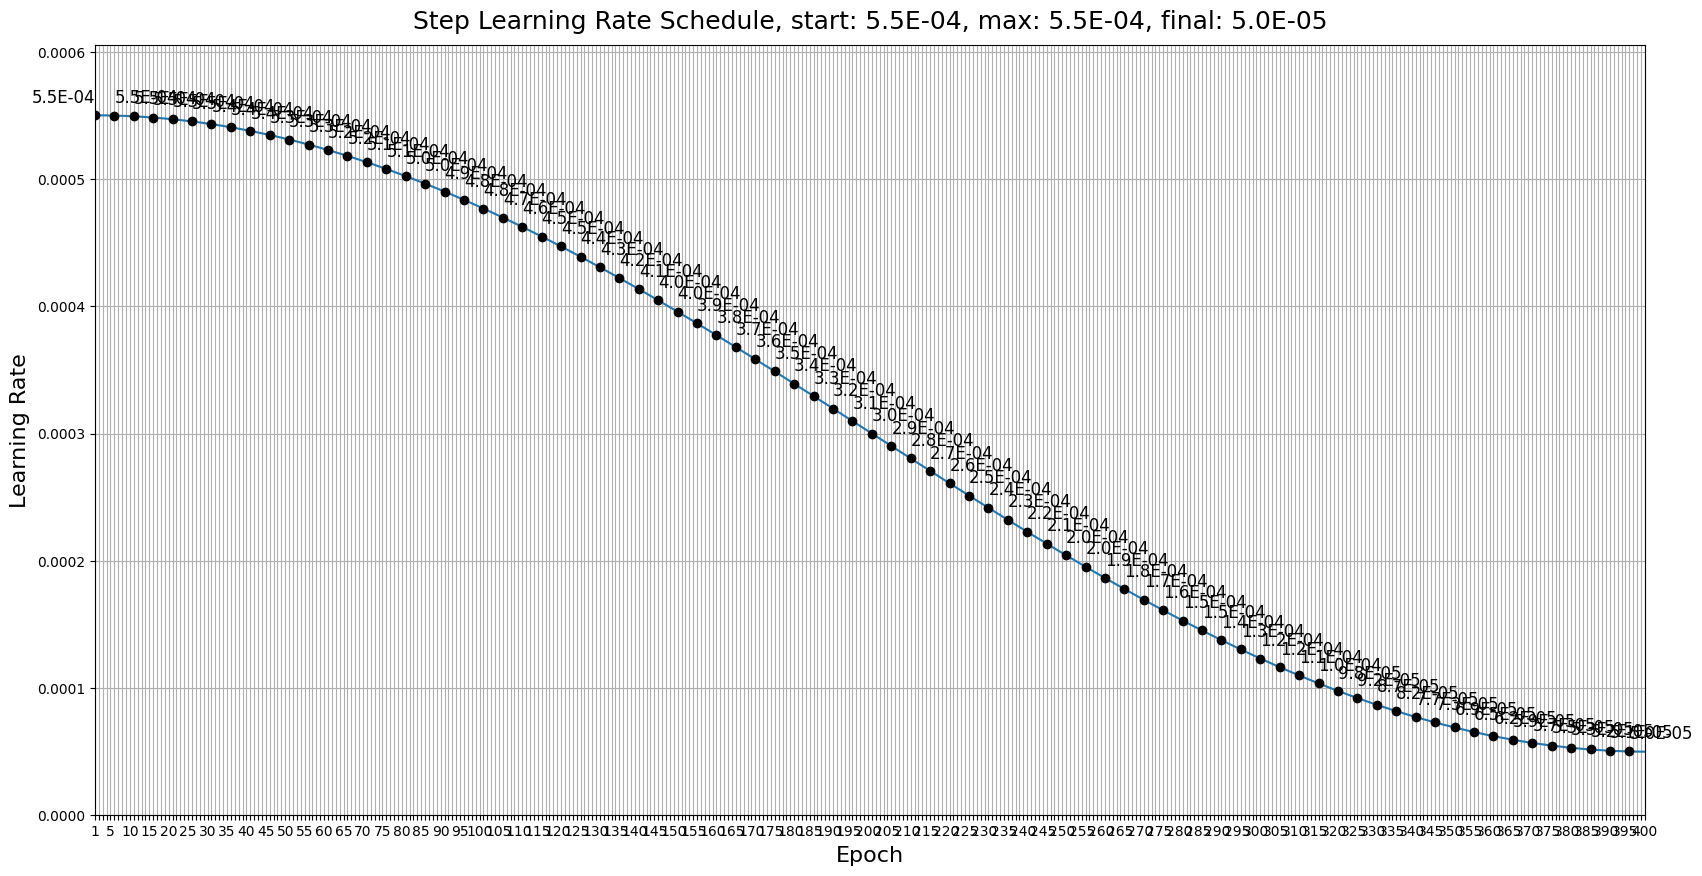

In [ ]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max + 5e-5

def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

In [ ]:
!mkdir working
save_folder = 'working'
try:
    os.mkdir(f'{save_folder}/weights')
except:
    pass

class save_model_callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch: int, logs=None):
        if epoch == 3 or (epoch+1)%25 == 0:
            self.model.save_weights(f"{save_folder}/weights/model_epoch_{epoch}.h5")

In [ ]:
steps_per_epoch = num_train//batch_size
val_steps_per_epoch = num_val//val_batch_size
print(steps_per_epoch)
print(val_steps_per_epoch)

2392
1


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    verbose = 2,
    callbacks=[
        save_model_callback(),
        lr_callback,
    ]
)

Epoch 1/400
2392/2392 - 211s - loss: 0.2657 - val_loss: 0.2141 - lr: 5.5000e-04 - 211s/epoch - 88ms/step
Epoch 2/400
2392/2392 - 116s - loss: 0.2131 - val_loss: 0.1955 - lr: 5.4999e-04 - 116s/epoch - 49ms/step
Epoch 3/400
2392/2392 - 116s - loss: 0.2023 - val_loss: 0.1874 - lr: 5.4997e-04 - 116s/epoch - 49ms/step
Epoch 4/400
2392/2392 - 119s - loss: 0.1952 - val_loss: 0.1798 - lr: 5.4993e-04 - 119s/epoch - 50ms/step
Epoch 5/400
2392/2392 - 116s - loss: 0.1875 - val_loss: 0.1724 - lr: 5.4988e-04 - 116s/epoch - 49ms/step
Epoch 6/400
2392/2392 - 116s - loss: 0.1813 - val_loss: 0.1668 - lr: 5.4981e-04 - 116s/epoch - 49ms/step
Epoch 7/400
2392/2392 - 116s - loss: 0.1769 - val_loss: 0.1617 - lr: 5.4972e-04 - 116s/epoch - 49ms/step
Epoch 8/400
2392/2392 - 116s - loss: 0.1733 - val_loss: 0.1579 - lr: 5.4962e-04 - 116s/epoch - 49ms/step
Epoch 9/400
2392/2392 - 116s - loss: 0.1702 - val_loss: 0.1551 - lr: 5.4951e-04 - 116s/epoch - 49ms/step
Epoch 10/400
2392/2392 - 116s - loss: 0.1676 - val_loss

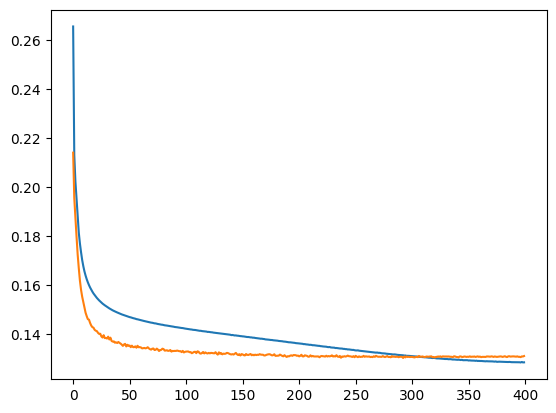

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])